# Publishing data analysis

In [39]:
import numpy as np
import pandas as pd

import theano.tensor as tt
import pymc3 as pm
import arviz as az

In [2]:
data = pd.read_excel("raw_data/data/Conley_Onder_JEPdata.xlsx")

In [3]:
data.head()

,PhD_ID,Rank,Year,AERPub
0,590,1,1987,7.054300
1,2971,1,1992,6.452617
2,210,1,1986,5.183317
3,2992,1,1993,4.700700
4,6544,1,1998,4.306967


In [4]:
data["AERPub_adj"] = data["AERPub"].apply(lambda x: x+0.001)
data.head()

,PhD_ID,Rank,Year,AERPub,AERPub_adj
0,590,1,1987,7.054300,7.055300
1,2971,1,1992,6.452617,6.453617
2,210,1,1986,5.183317,5.184317
3,2992,1,1993,4.700700,4.701700
4,6544,1,1998,4.306967,4.307967


# Simple gamma models

Start with simple models where which treat all PhDs like they came from the same school and should be modeled under the same distribution.

We try the same hierarchy twice with different priors, the latter informed by the... first one.

In [6]:
with pm.Model() as simple_model:
    shape = pm.Uniform("shape", lower=0, upper=5)
    scale = pm.Uniform("scale", lower=0, upper=5)
    gamma = pm.Gamma("likelihood", alpha = shape, beta = scale, observed = data.AERPub_adj)
    
    inf_data = pm.sample(draws = 6000, tune=2500,  cores=4, chains=4, step=pm.NUTS(), return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale, shape]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.7118110448116068, but should be close to 0.8. Try to increase the number of tuning steps.


In [42]:
with pm.Model() as simple_model2:
    shape = pm.HalfNormal("shape_hn", sd=1)
    scale = pm.HalfNormal("scale_hn", sd=1)
    gamma = pm.Gamma("likelihood2", alpha = shape, beta = scale, observed = data.AERPub_adj)
    
    inf_data2 = pm.sample(draws = 4000,  cores=4, chains=4, step=pm.NUTS(), return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale_hn, shape_hn]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 32 seconds.


In [41]:
with pm.Model() as simple_model3:
    shape = pm.HalfNormal("shape_hn2", sd=0.5)
    scale = pm.HalfNormal("scale_hn2", sd=1.5)
    gamma = pm.Gamma("likelihood3", alpha = shape, beta = scale, observed = data.AERPub_adj)
    
    inf_data3 = pm.sample(tune=3000, draws = 2000,  chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [scale_hn2, shape_hn2]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 37 seconds.


In [66]:
# Note this is quite slow.
# inf_data.to_netcdf("raw_data/simple_model_inf.nc");
# inf_data2.to_netcdf("raw_data/simple_model2_inf.nc")
inf_data3.to_netcdf("raw_data/simple_model3_inf.nc")
#inf_data = az.from_netcdf("raw_data/simple_model_inf.nc")

'raw_data/simple_model3_inf.nc'

In [29]:
print("Free variables: ", simple_model.free_RVs)
print("Observed variables: ", simple_model.observed_RVs)
print("Deterministics: ", simple_model.deterministics)
print("----")
print("Free variables: ", simple_model2.free_RVs)
print("Observed variables: ", simple_model2.observed_RVs)
print("Deterministics: ", simple_model2.deterministics)

Free variables:  [shape_interval__, scale_interval__]
Observed variables:  [liklihood]
Deterministics:  [shape, scale]
----
Free variables:  [shape_hn_log__, scale_hn_log__]
Observed variables:  [likelihood2]
Deterministics:  [shape_hn, scale_hn]


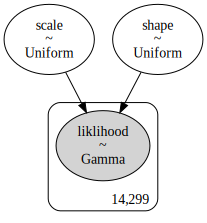

In [9]:
pm.model_to_graphviz(simple_model)

### Evaluate and criticize the trace

1.   Check the summary.
   1.   Verify $r hat<1.01$
   1.   Verify ESS is roughly $>=$50% of raw sample size
   1.   Check the HDI for any params
1.   Check a trace plot. See if the chains mixed.
1.   Check the forest plot - look for uncertainty in estimates and variance in chains
1.   Check autocorrelation plot. Verify that the chains aren't too heavily autocorrelated.

Some notes on the comparison:  
*   Most graphs show very similar results
*   The ESS is higher with the better priors

In [11]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
shape,0.248,0.002,0.244,0.253,0.0,0.0,10124.0,10122.0,10124.0,11163.0,1.0
scale,1.624,0.032,1.564,1.682,0.0,0.0,10102.0,10092.0,10115.0,11697.0,1.0


In [30]:
az.summary(inf_data2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
shape_hn,0.248,0.002,0.244,0.252,0.0,0.0,9531.0,9529.0,9527.0,9767.0,1.0
scale_hn,1.623,0.032,1.564,1.682,0.0,0.0,9393.0,9391.0,9393.0,9859.0,1.0


In [43]:
az.summary(inf_data3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
shape_hn2,0.248,0.002,0.244,0.253,0.0,0.0,4532.0,4532.0,4532.0,4539.0,1.0
scale_hn2,1.623,0.032,1.565,1.683,0.0,0.0,4809.0,4809.0,4817.0,5049.0,1.0


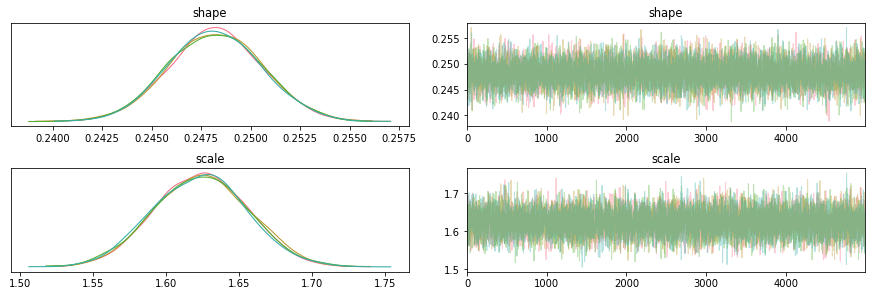

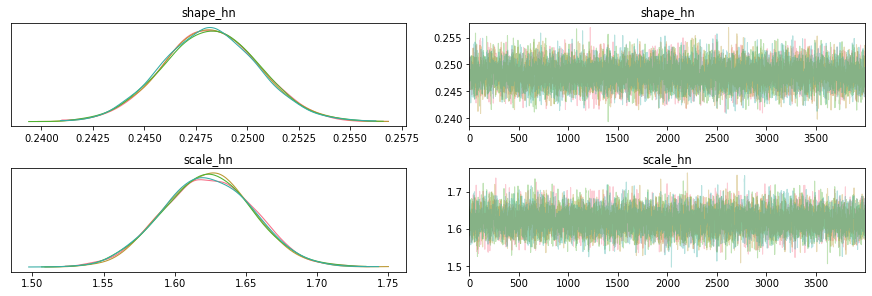

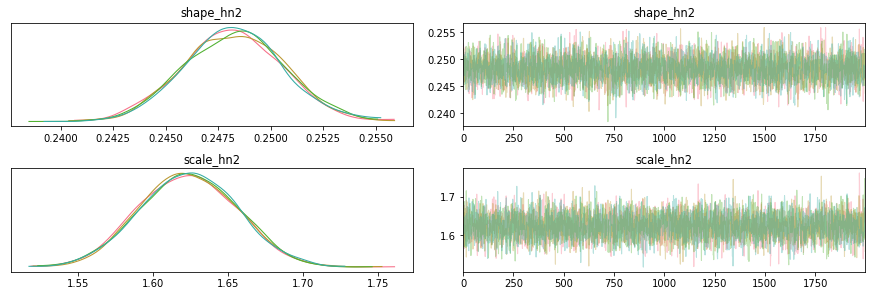

In [65]:
az.plot_trace(inf_data);
az.plot_trace(inf_data2);
az.plot_trace(inf_data3);

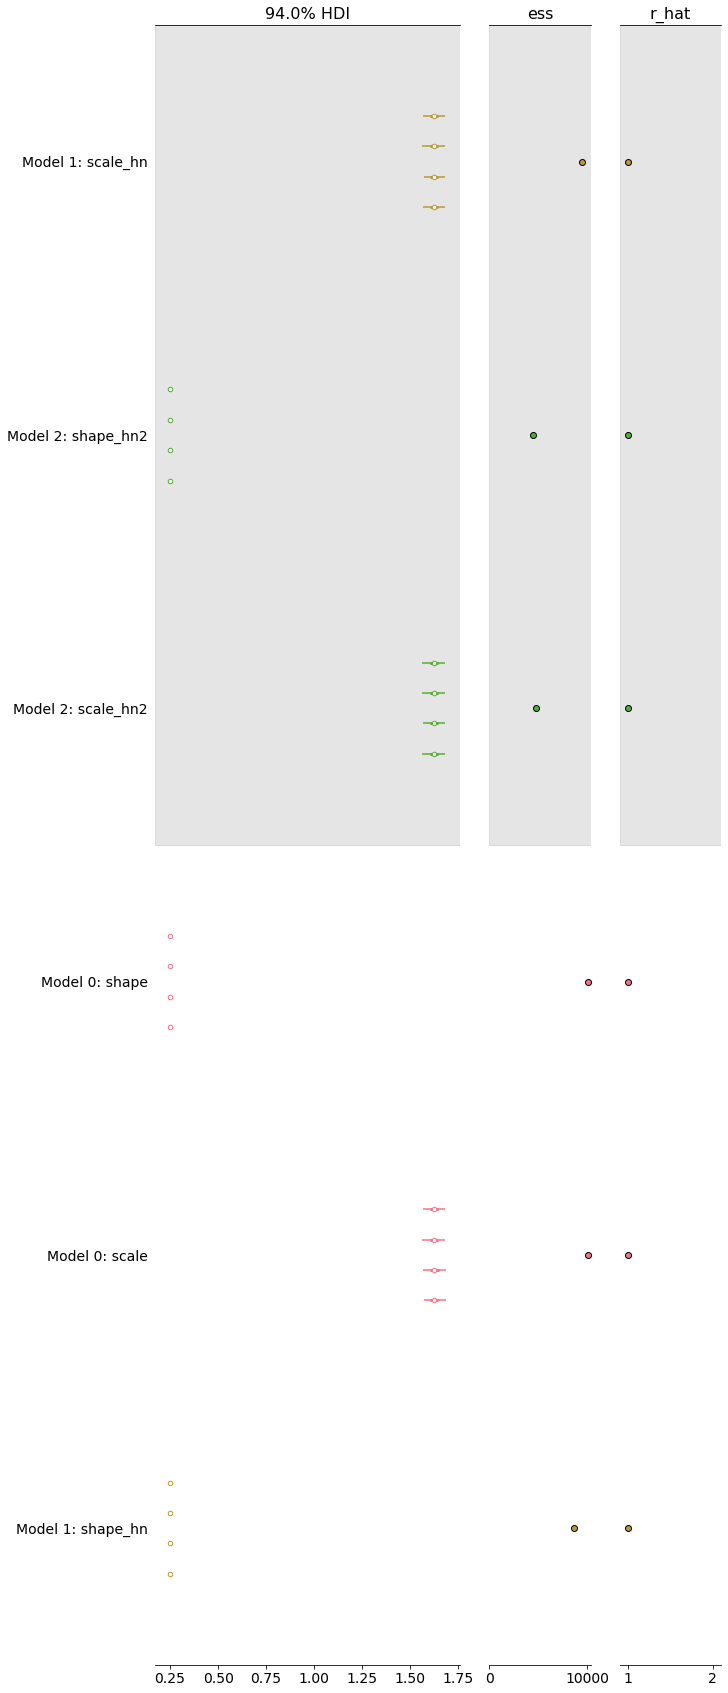

In [45]:
az.plot_forest([inf_data, inf_data2, inf_data3], r_hat=True, ess=True);

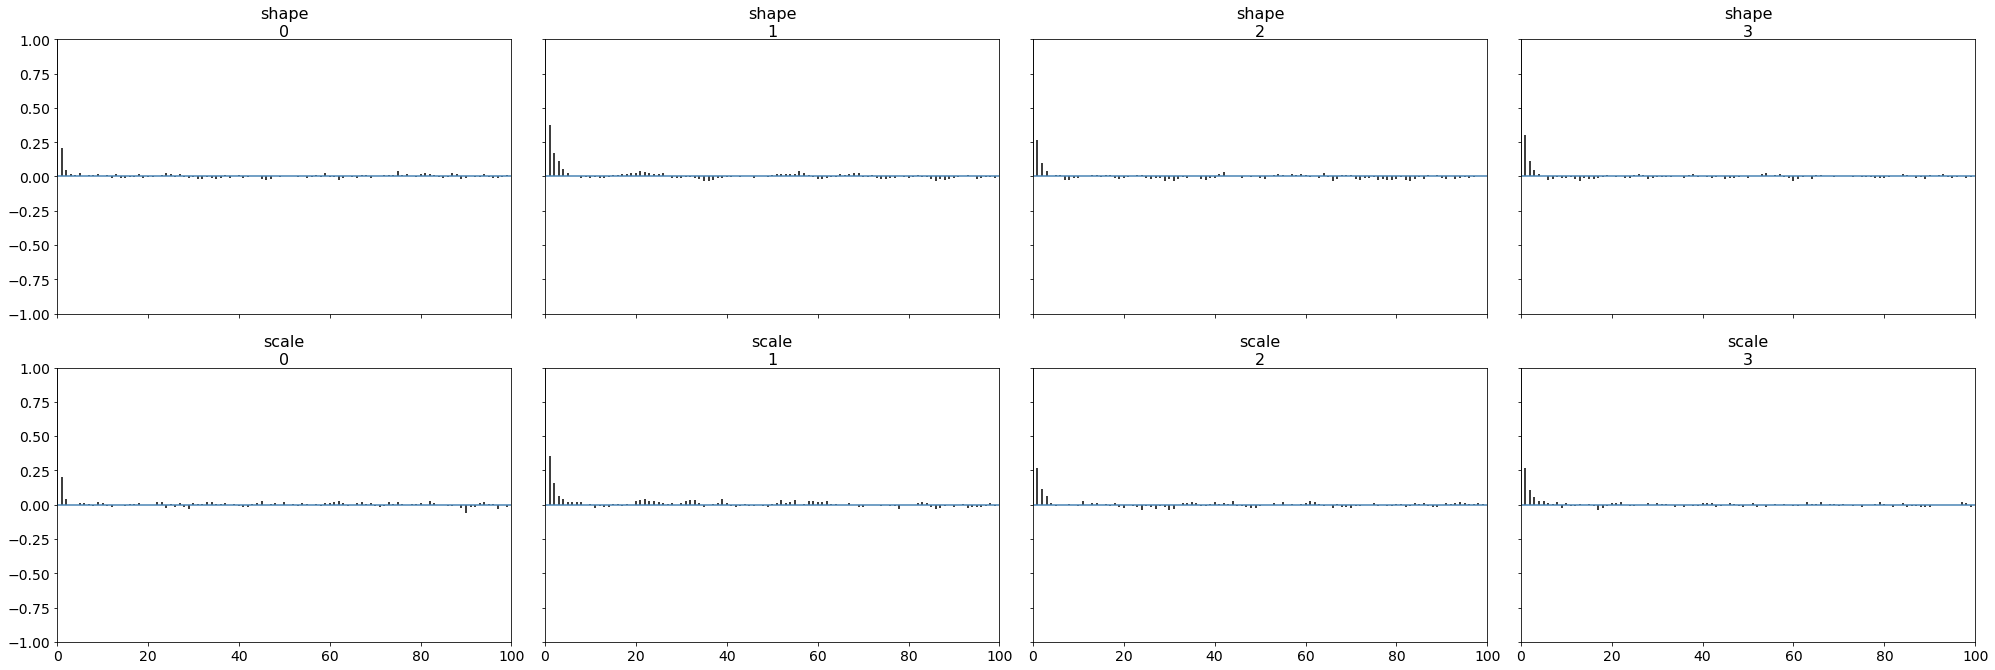

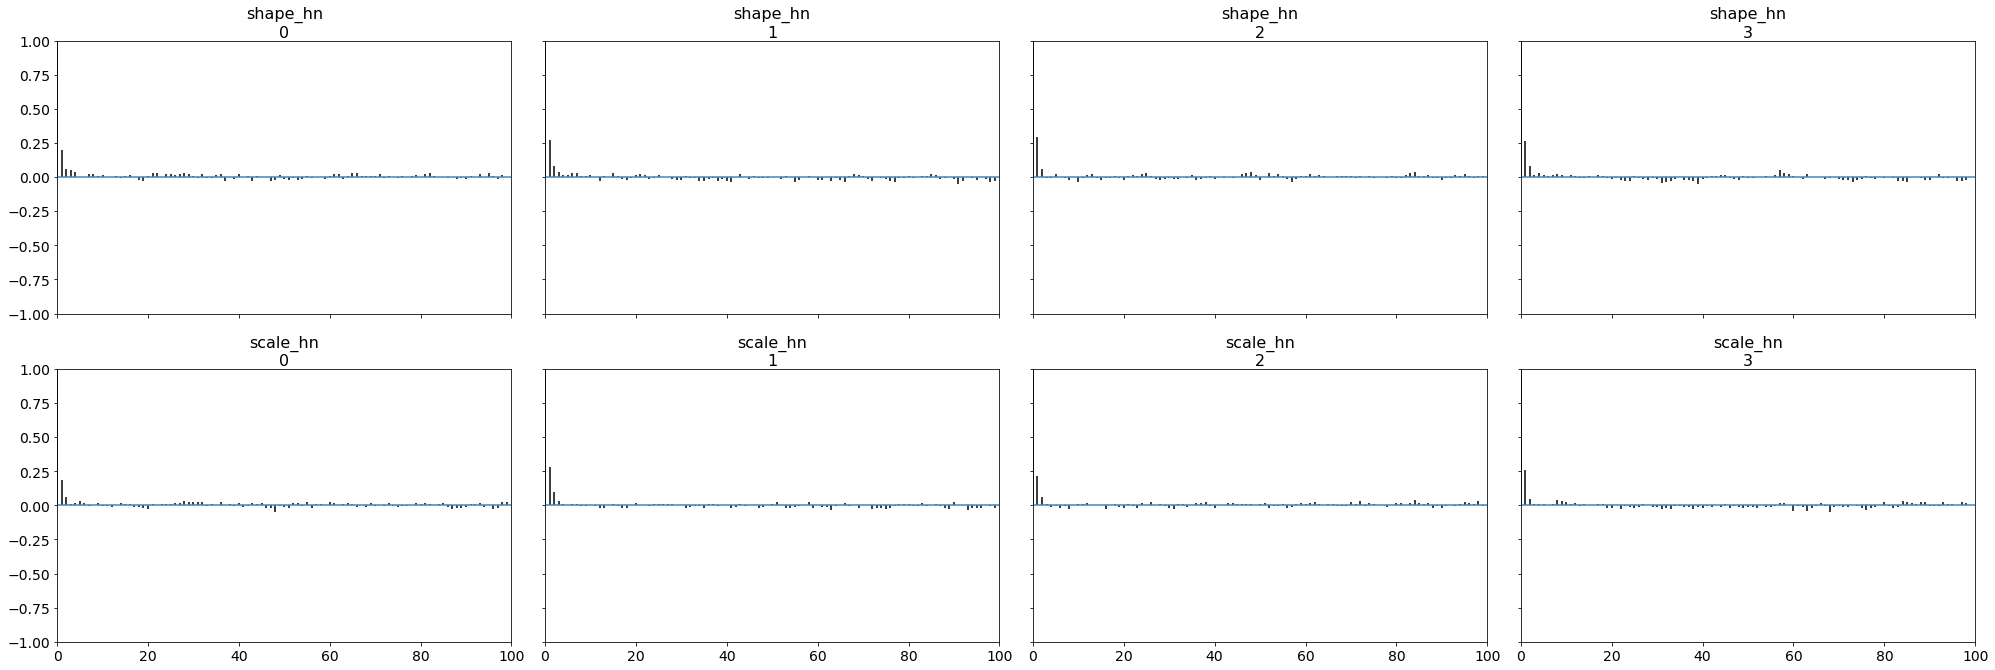

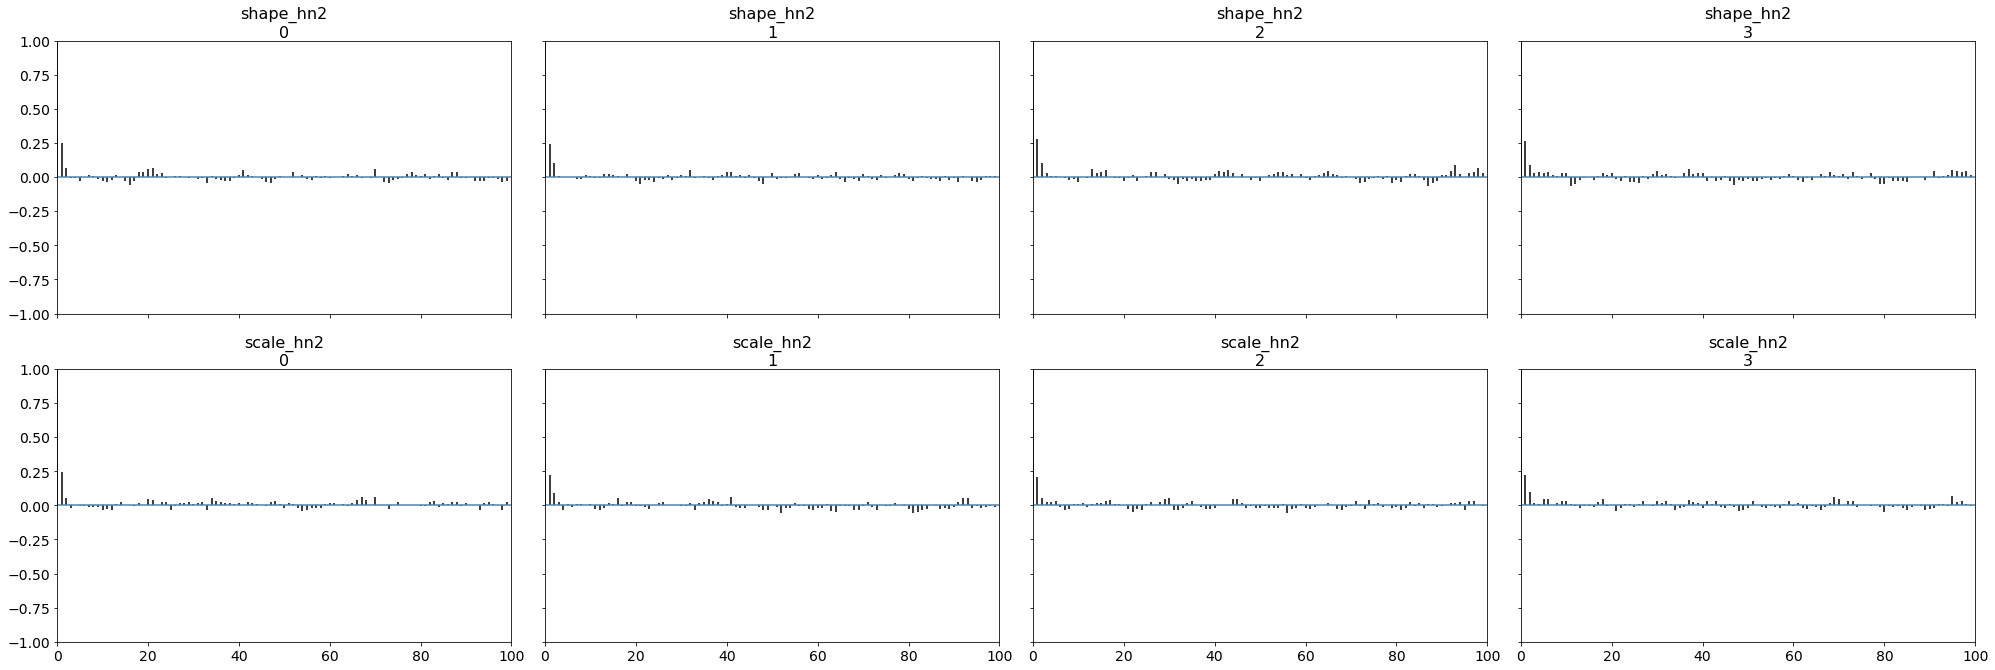

In [46]:
az.plot_autocorr(inf_data);
az.plot_autocorr(inf_data2);
az.plot_autocorr(inf_data3);

## Evaluate the posterior

1.   Verify the distributions are indeed unimodal
1.   Use sample_predictive_posterior to see if the posterior is similar to observed data
1.   Plot the sample_predictive_posterior

Since the second run had better ESS and other things mostly the same, we will use that model for our posterior predictive sampling.

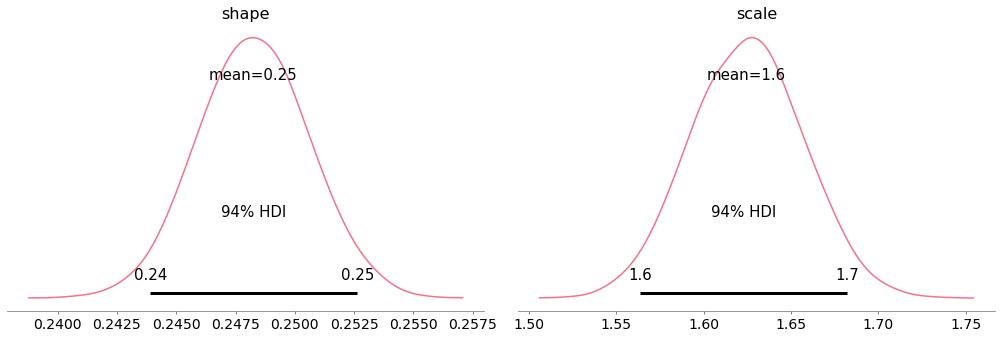

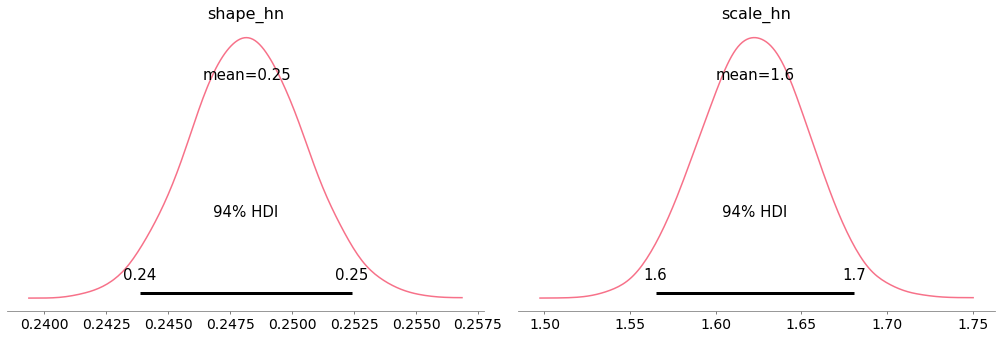

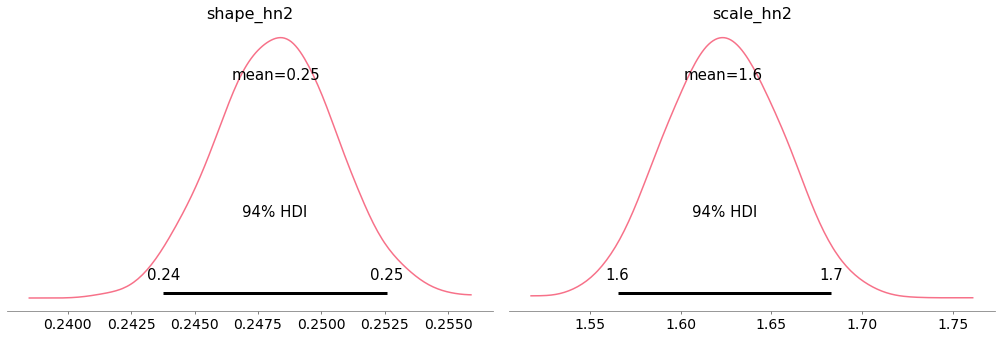

In [47]:
az.plot_posterior(inf_data);
az.plot_posterior(inf_data2);
az.plot_posterior(inf_data3);

In [37]:
with simple_model2:
    posterior_samples = pm.sample_posterior_predictive(inf_data2.posterior)

inf_data_posterior = az.from_pymc3(posterior_predictive = posterior_samples)
concatonated_samples = az.concat(inf_data2, inf_data_posterior, inplace=False)


/Users/matthewfritze/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [49]:
with simple_model3:
    posterior_samples2 = pm.sample_posterior_predictive(inf_data3.posterior)

inf_data_posterior2 = az.from_pymc3(posterior_predictive = posterior_samples2)
concatonated_samples2 = az.concat(inf_data3, inf_data_posterior2, inplace=False)

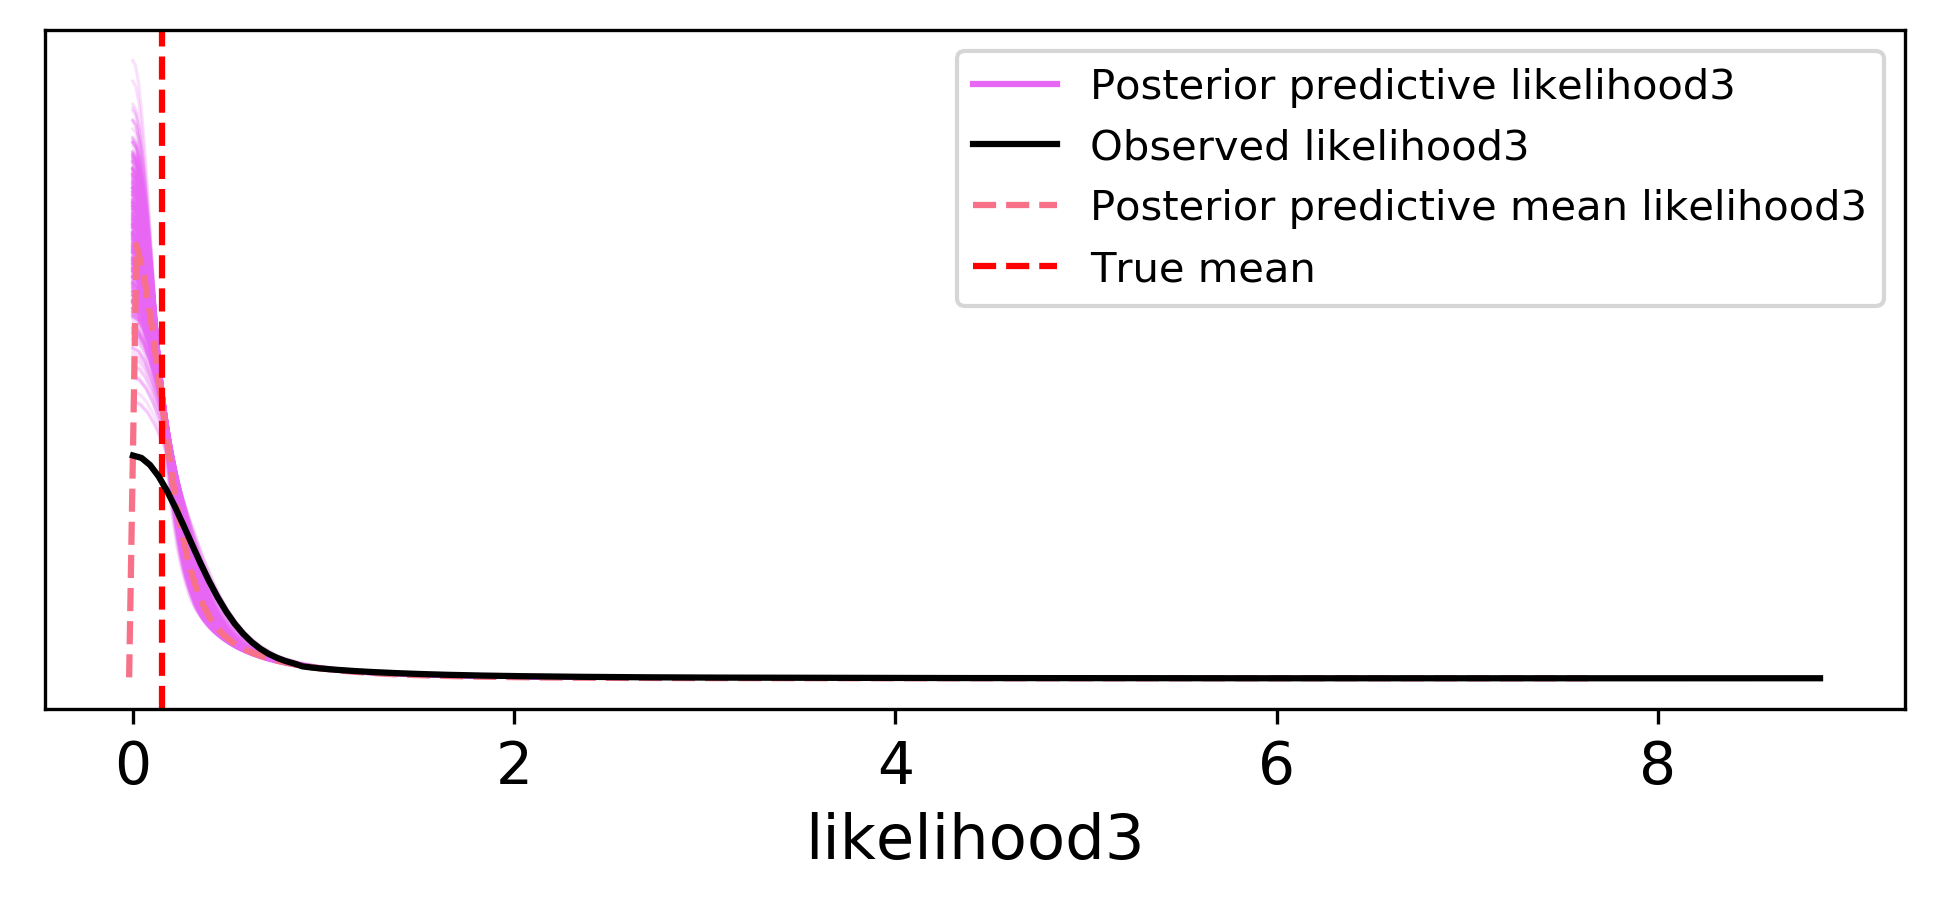

In [64]:
fig, ax = plt.subplots(figsize=(8,3));
fig.set_dpi(300);
az.plot_ppc(concatonated_samples, ax=ax, num_pp_samples=500);
ax.axvline(data.AERPub_adj.mean(), ls="--", color="r", label="True mean");
ax.legend(fontsize=10, loc=1);

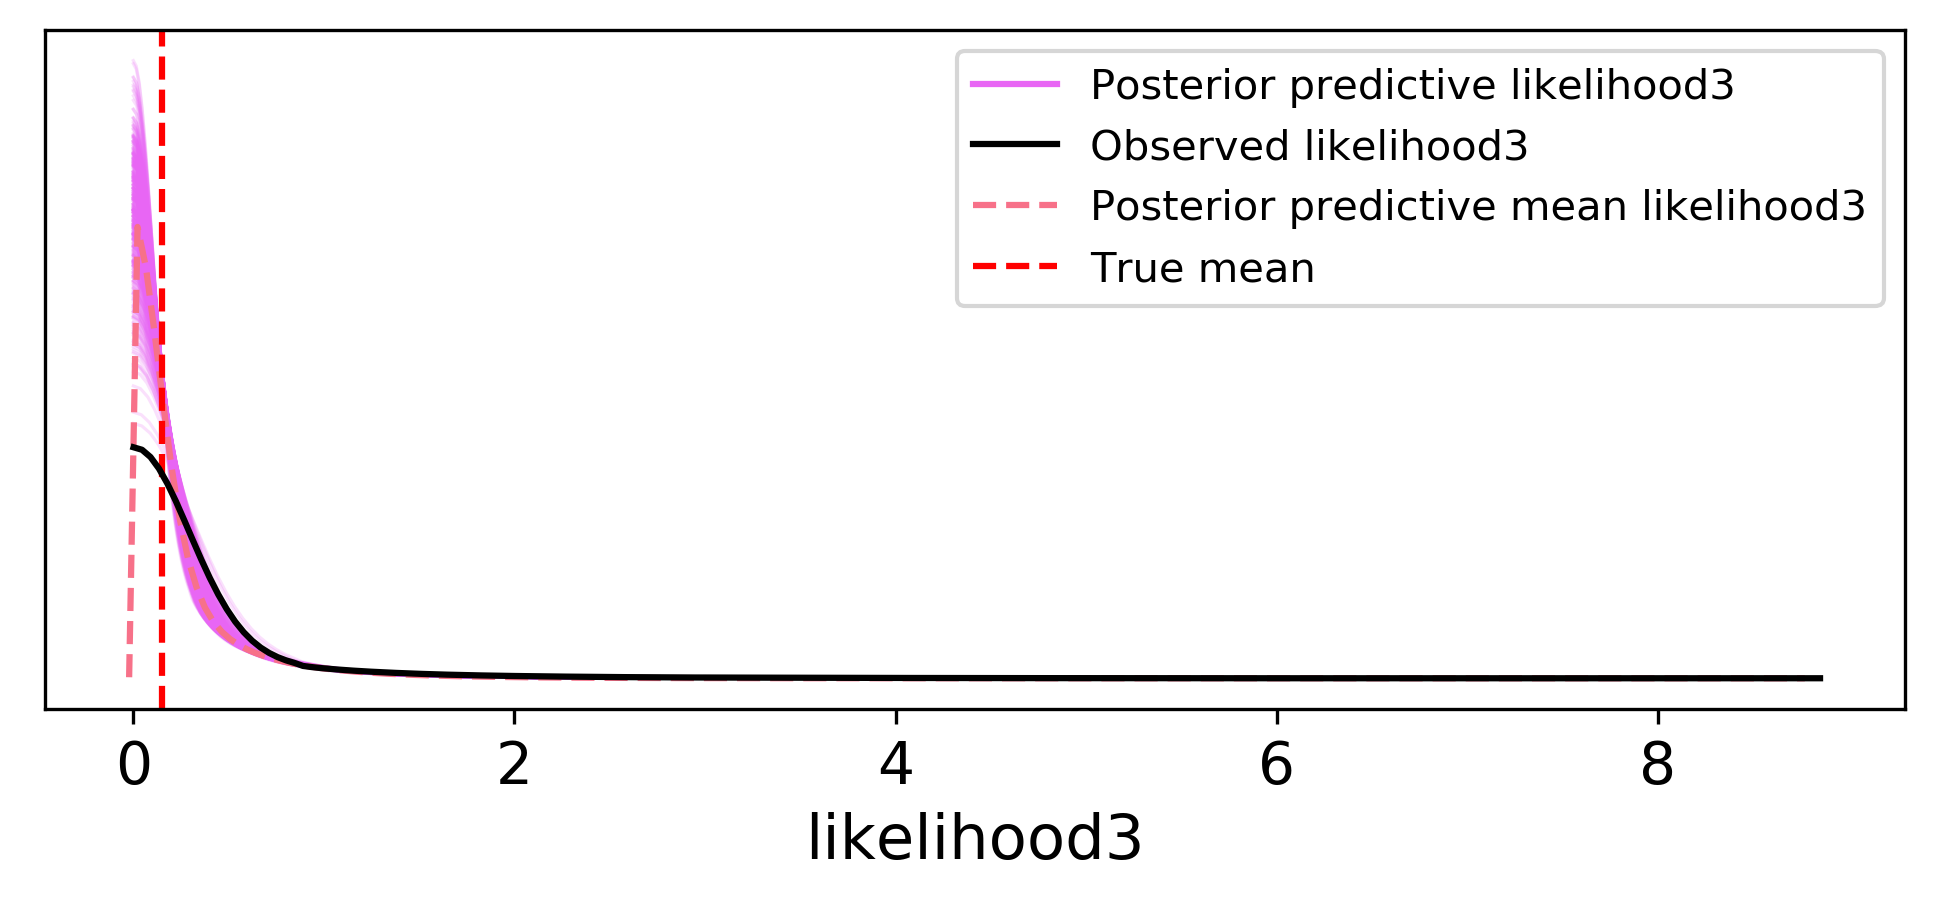

In [62]:
fig, ax = plt.subplots(figsize=(8,3));
fig.set_dpi(300);
az.plot_ppc(concatonated_samples2, ax=ax, num_pp_samples=500);
ax.axvline(data.AERPub_adj.mean(), ls="--", color="r", label="True mean");
ax.legend(fontsize=10, loc=1);

# Simple Exponential Models

Similar to the gamma models, but we use an exponential distribution as the likelihood instead.

In [71]:
with pm.Model() as simple_ex_model:
    decay = pm.HalfNormal("decay", sd=5)
    exponential = pm.Exponential("likelihood", lam = decay, observed = data.AERPub_adj)
    
    inf_data_exp = pm.sample(tune=3000, draws = 2000,  chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [decay]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 26 seconds.


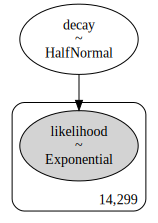

In [72]:
pm.model_to_graphviz(simple_ex_model)

In [73]:
az.summary(inf_data_exp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
decay,6.542,0.055,6.438,6.645,0.001,0.001,3646.0,3646.0,3633.0,5954.0,1.0


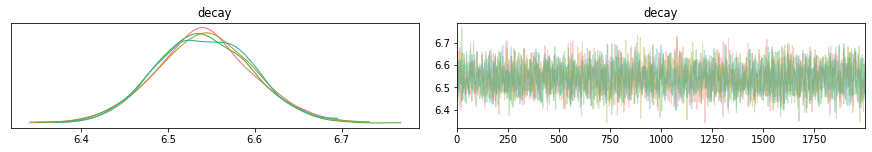

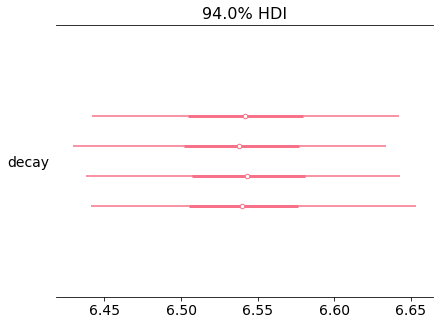

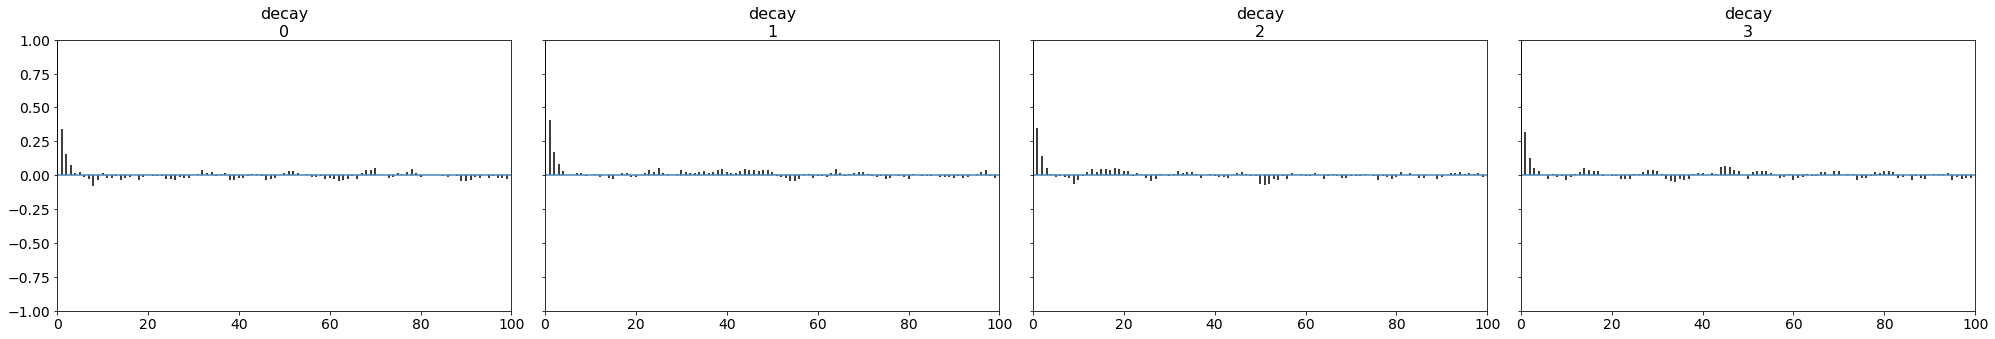

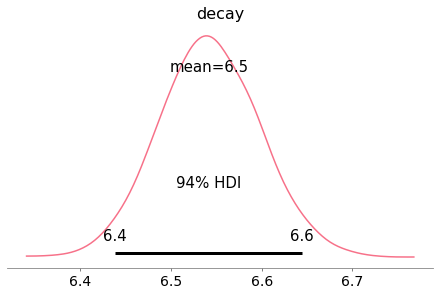

In [75]:
az.plot_trace(inf_data_exp);
az.plot_forest(inf_data_exp);
az.plot_autocorr(inf_data_exp);
az.plot_posterior(inf_data_exp);

In [76]:
with simple_ex_model:
    posterior_samples_exp = pm.sample_posterior_predictive(inf_data_exp.posterior)

inf_data_posterior_exp = az.from_pymc3(posterior_predictive = posterior_samples_exp)
concatonated_samples_exp = az.concat(inf_data_exp, inf_data_posterior_exp, inplace=False)

/Users/matthewfritze/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


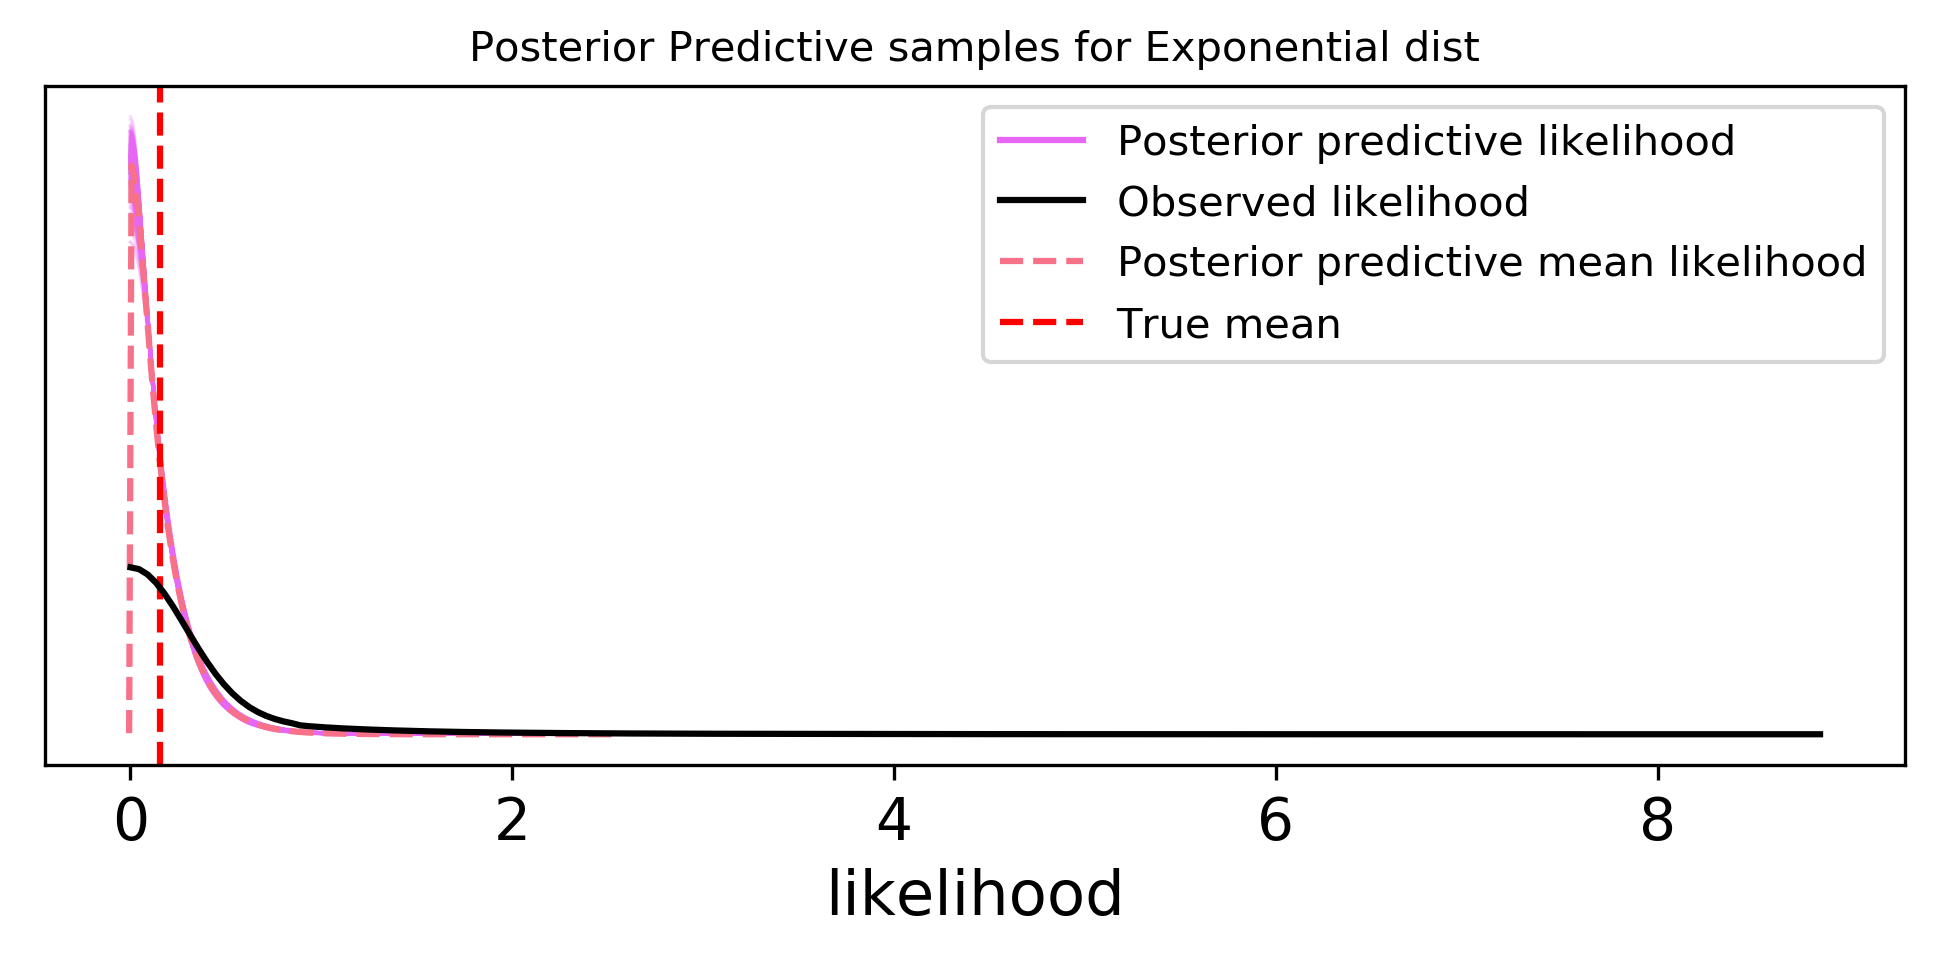

In [77]:
fig, ax = plt.subplots(figsize=(8,3));
fig.set_dpi(300);
az.plot_ppc(concatonated_samples_exp, ax=ax, num_pp_samples=500);
ax.axvline(data.AERPub_adj.mean(), ls="--", color="r", label="True mean");
ax.set_title("Posterior Predictive samples for Exponential dist", fontsize=10)
ax.legend(fontsize=10, loc=1);

# TODO - Wednesday

*   It looks like the actual curve (observed likelihood) is in fact HalfNormal. Try that next.
*   Try out sampling predictive priors and compare the models
*   Build that multi level!

In [78]:
with pm.Model() as simple_hn_model:
    sd = pm.HalfNormal("sdev", sd=5)
    half_normal = pm.HalfNormal("likelihood", sd=sd, observed = data.AERPub_adj)
    
    inf_data_hn = pm.sample(tune=3000, draws = 2000,  chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sdev]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 34 seconds.


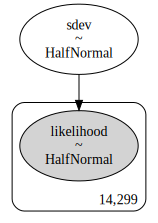

In [79]:
pm.model_to_graphviz(simple_hn_model)

In [80]:
az.summary(inf_data_hn)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sdev,0.48,0.003,0.475,0.485,0.0,0.0,3698.0,3698.0,3701.0,5775.0,1.0


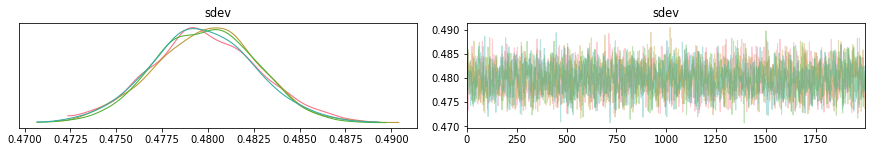

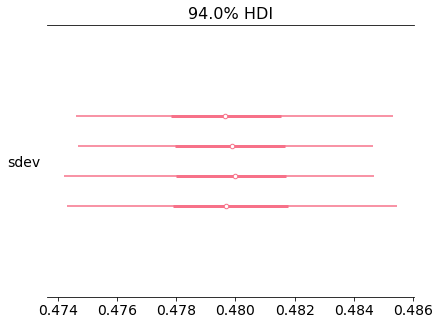

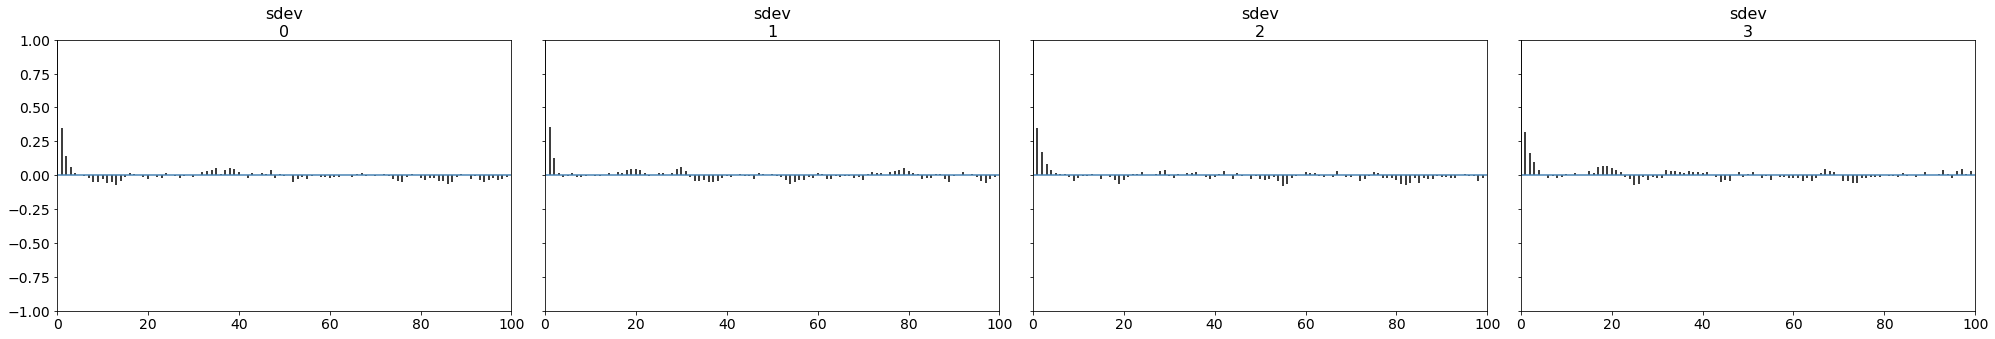

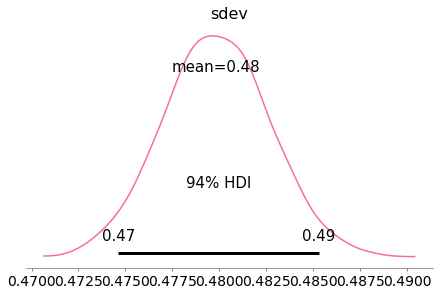

In [81]:
az.plot_trace(inf_data_hn);
az.plot_forest(inf_data_hn);
az.plot_autocorr(inf_data_hn);
az.plot_posterior(inf_data_hn);

In [82]:
with simple_hn_model:
    posterior_samples_hn = pm.sample_posterior_predictive(inf_data_hn.posterior)
    

inf_data_posterior_hn = az.from_pymc3(posterior_predictive = posterior_samples_hn)
concatonated_samples_hn = az.concat(inf_data_hn, inf_data_posterior_hn, inplace=False)

/Users/matthewfritze/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


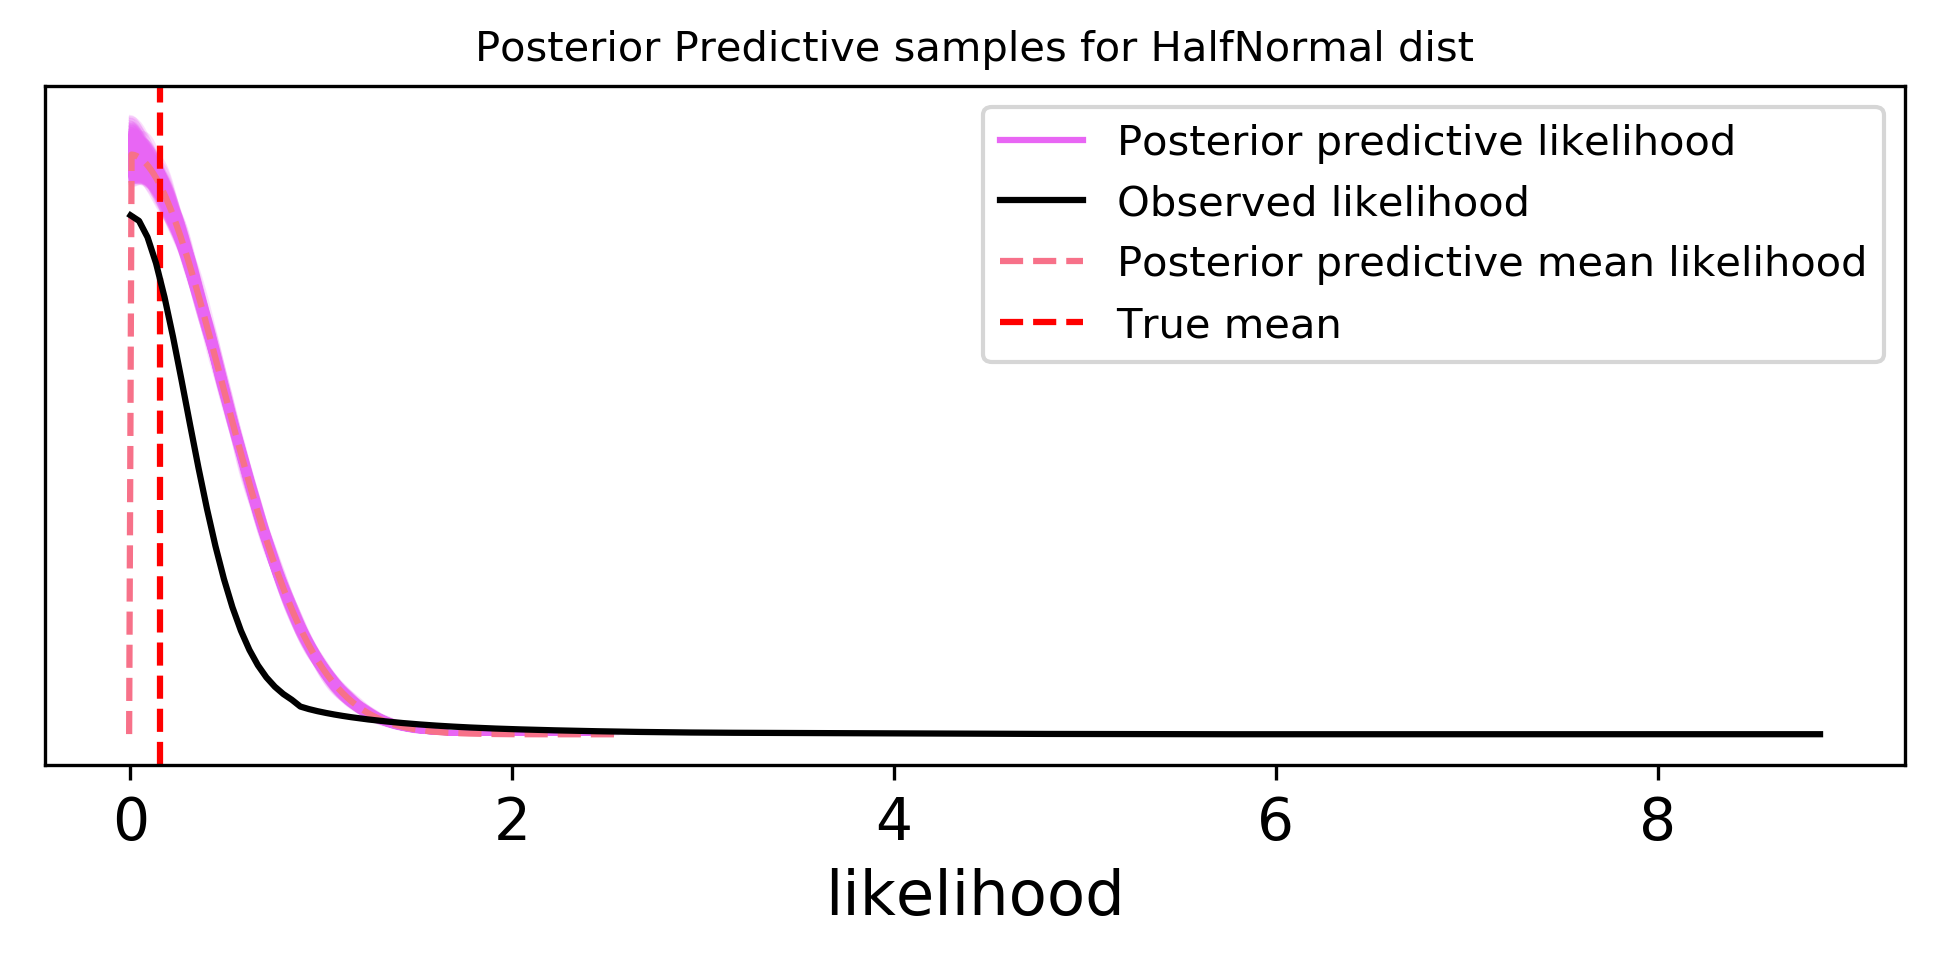

In [84]:
fig, ax = plt.subplots(figsize=(8,3));
fig.set_dpi(300);
az.plot_ppc(concatonated_samples_hn, ax=ax, num_pp_samples=3000);
ax.axvline(data.AERPub_adj.mean(), ls="--", color="r", label="True mean");
ax.set_title("Posterior Predictive samples for HalfNormal dist", fontsize=10)
ax.legend(fontsize=10, loc=1);

# Multi level models

*   Build a model that incorporates the school rank
*   Then use the example comparison graph, right above the "varying intercept model" line

In [119]:
coords = {"obs_id": np.arange(data.index.size), "SchoolRank": np.arange(32)}
with pm.Model(coords=coords) as school_model:
    rank_idx = pm.Data("rank_idx", data.Rank.values, dims="obs_id")
    
    # Hyper priors
    sigma_a = pm.Uniform("sigma_a", 0, 2)
    
    # Varying standard dev. per school
    sigma = pm.HalfNormal("school_sigma", sd=sigma_a, dims="SchoolRank")
    
    # Expected sd per school
    school_sigma = sigma[rank_idx]
    
    # Should probably through in some model error here and let it mix
    # error = pm.Exponential("error", 1)
    inf_data_ml = pm.HalfNormal("y", sd=school_sigma, observed = data.AERPub_adj, dims="obs_id")

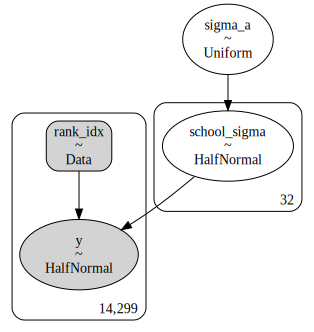

In [120]:
pm.model_to_graphviz(school_model)

In [121]:
print("Free variables: ", school_model.free_RVs)
print("Observed variables: ", school_model.observed_RVs)
print("Deterministics: ", school_model.deterministics)

Free variables:  [sigma_a_interval__, school_sigma_log__]
Observed variables:  [y]
Deterministics:  [sigma_a, school_sigma]


In [122]:
with school_model:
    mlm_idata = pm.sample(tune=3000, draws=3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [school_sigma, sigma_a]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 50 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [123]:
az.summary(mlm_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.628,0.085,0.478,0.795,0.001,0.001,5941.0,5337.0,7117.0,3227.0,1.0
school_sigma[0],0.502,0.394,0.000,1.223,0.006,0.004,4518.0,4518.0,3673.0,2895.0,1.0
school_sigma[1],1.045,0.035,0.978,1.107,0.000,0.000,7149.0,7120.0,7162.0,3831.0,1.0
school_sigma[2],0.690,0.024,0.647,0.736,0.000,0.000,8770.0,8687.0,8854.0,3931.0,1.0
school_sigma[3],0.663,0.027,0.614,0.714,0.000,0.000,8252.0,8053.0,8587.0,3743.0,1.0
school_sigma[4],0.738,0.027,0.689,0.790,0.000,0.000,9104.0,8952.0,9319.0,3756.0,1.0
school_sigma[5],1.202,0.044,1.125,1.287,0.000,0.000,7962.0,7924.0,7983.0,3939.0,1.0
school_sigma[6],0.527,0.018,0.493,0.562,0.000,0.000,8225.0,8160.0,8276.0,3820.0,1.0
school_sigma[7],0.772,0.043,0.690,0.852,0.001,0.000,6694.0,6500.0,6954.0,3600.0,1.0
school_sigma[8],0.919,0.043,0.840,0.999,0.000,0.000,7633.0,7407.0,7758.0,3756.0,1.0


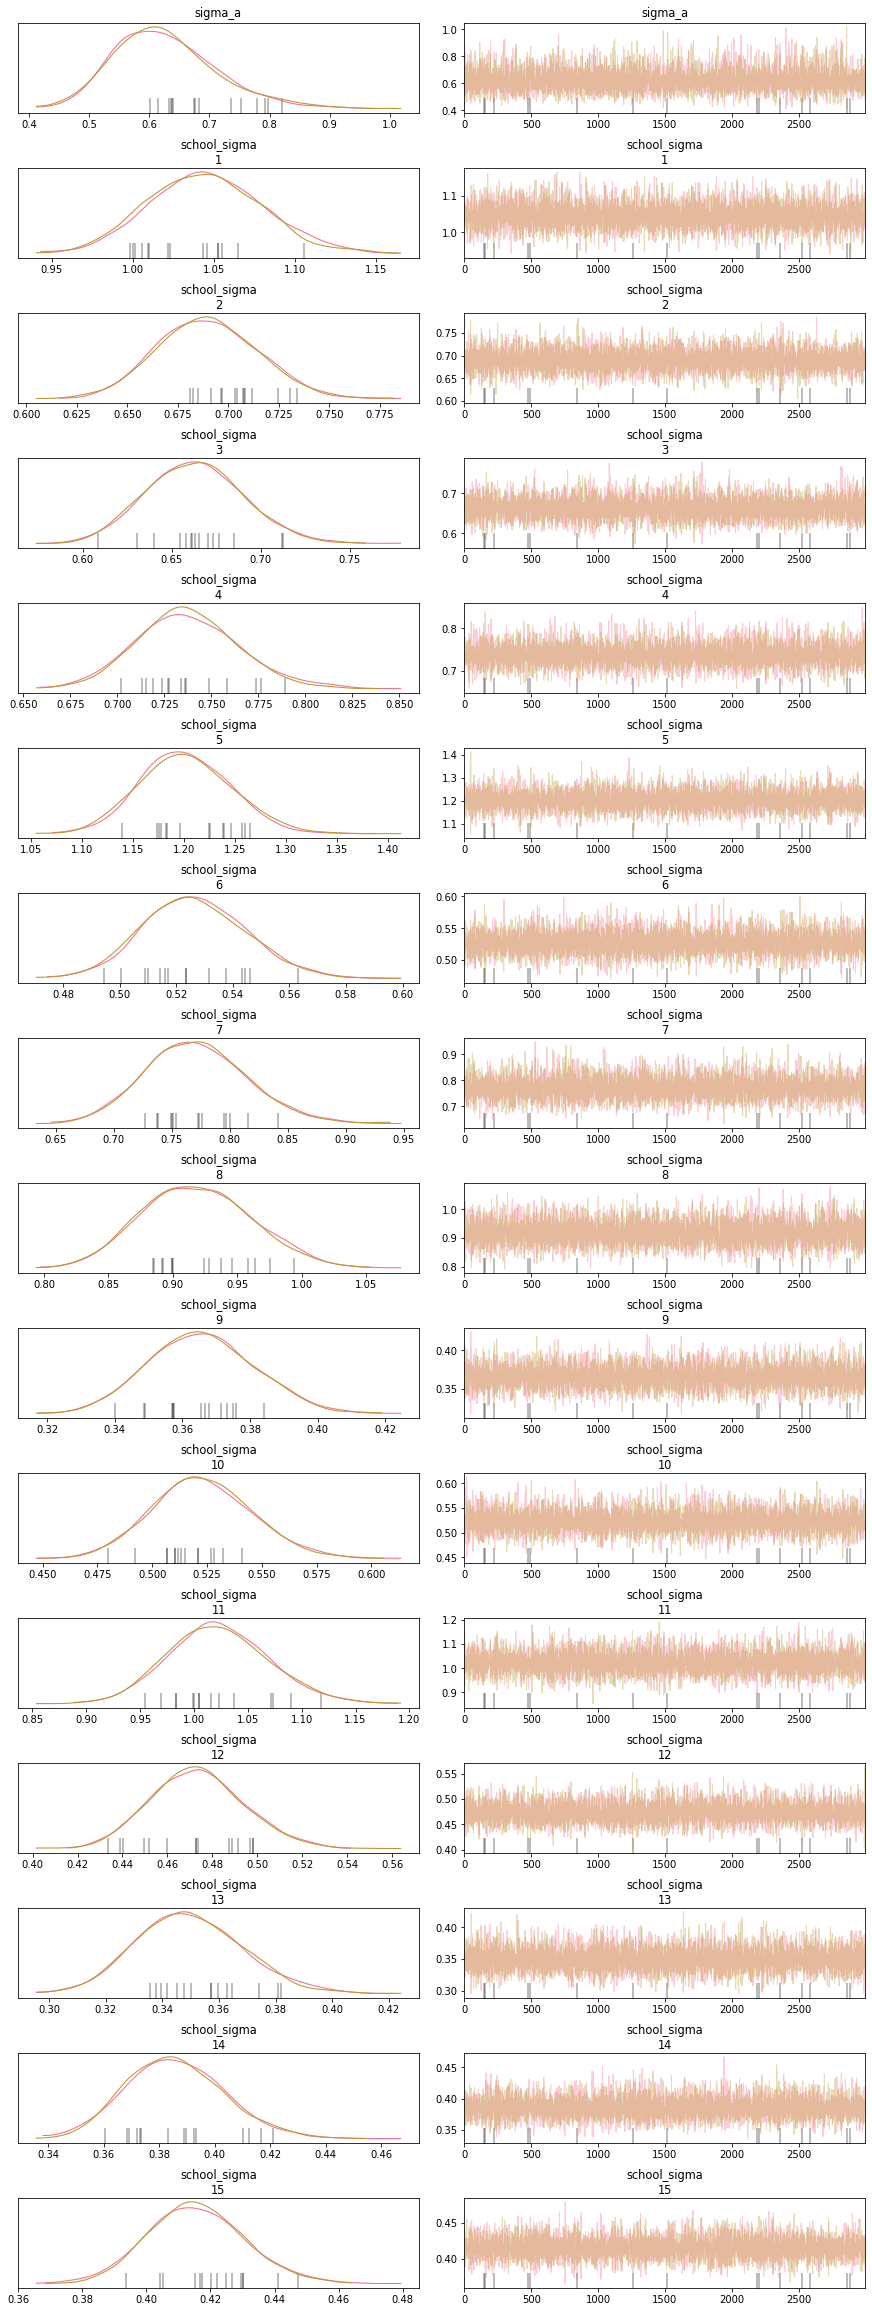

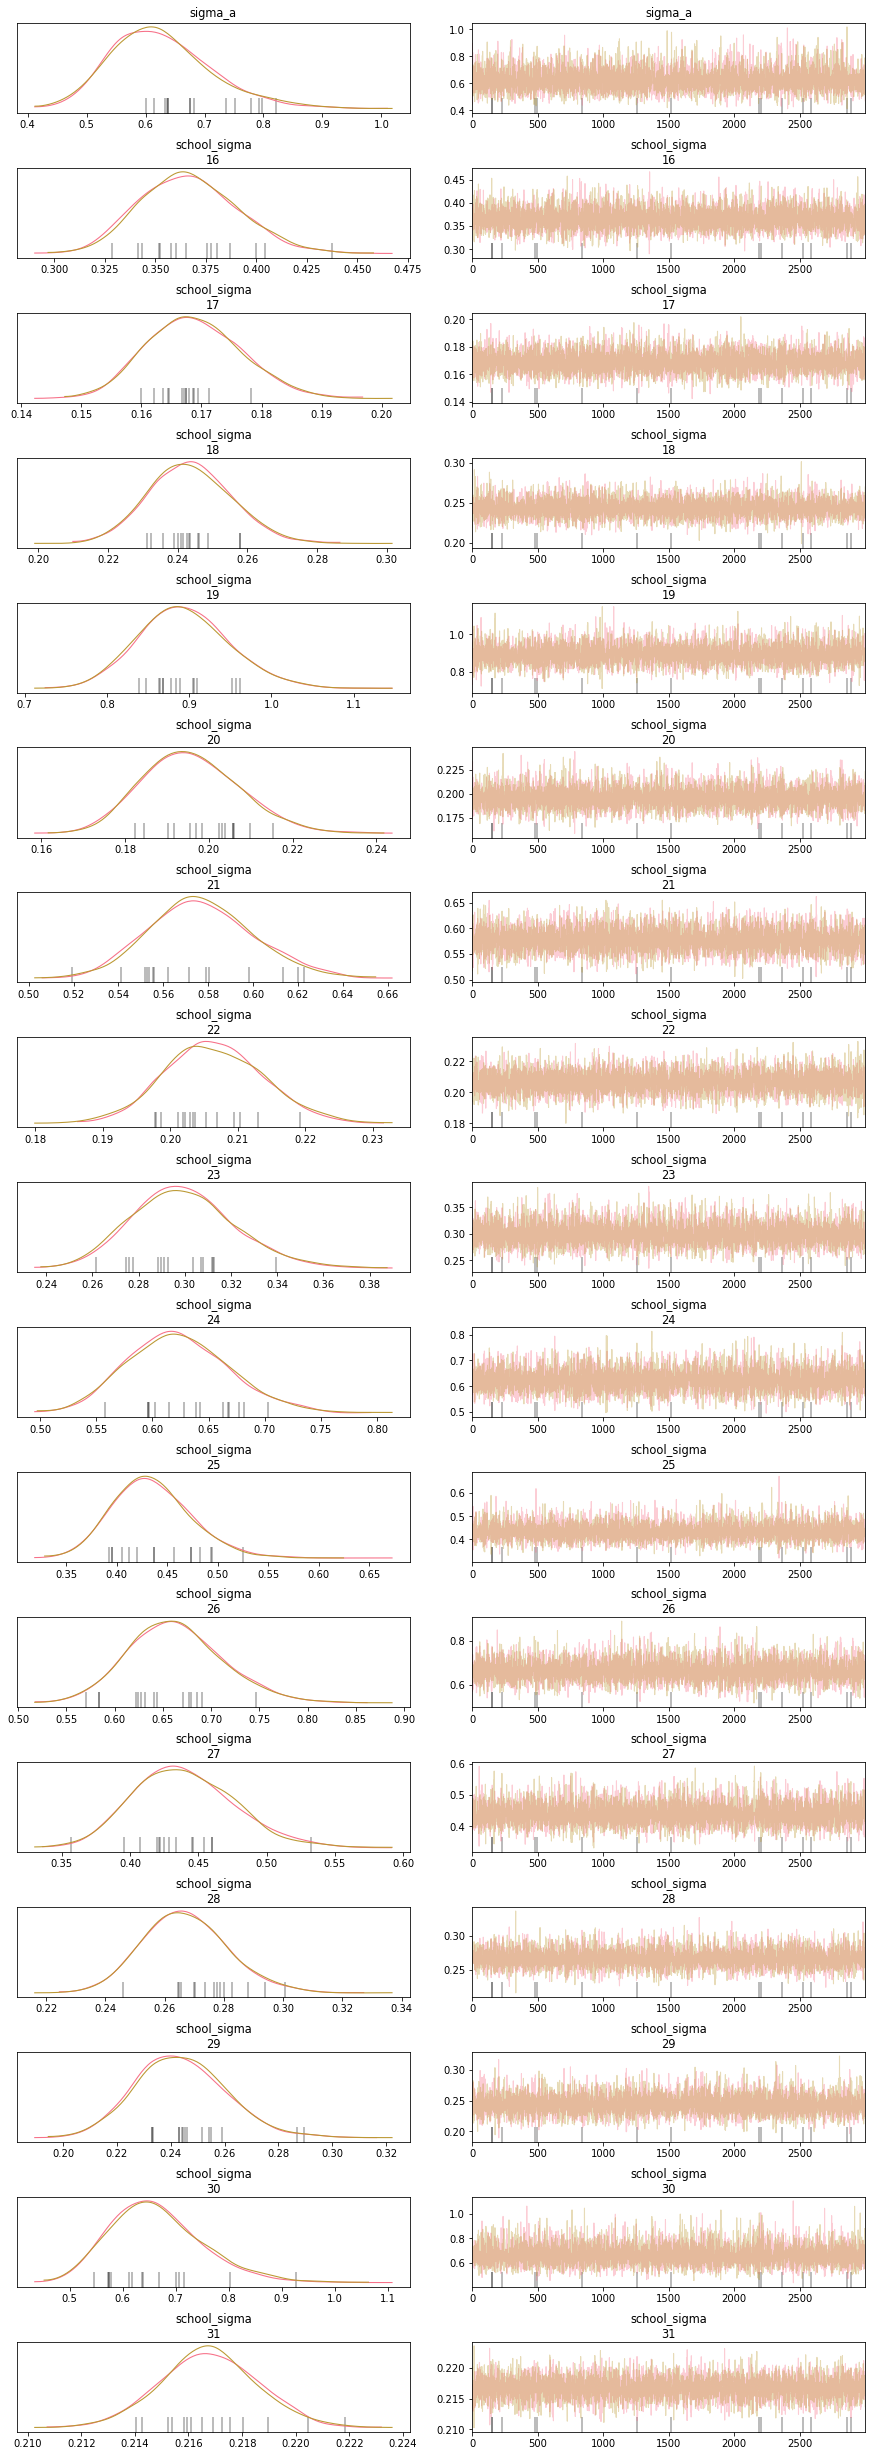

In [147]:
# Plot first half, then second half of the posteriors to keep matplotlib max_plots happy
mlm_idata_a = mlm_idata.sel(SchoolRank = np.arange(1,16))
mlm_idata_b = mlm_idata.sel(SchoolRank = np.arange(16,32))
pm.plot_trace(mlm_idata_a);
pm.plot_trace(mlm_idata_b);

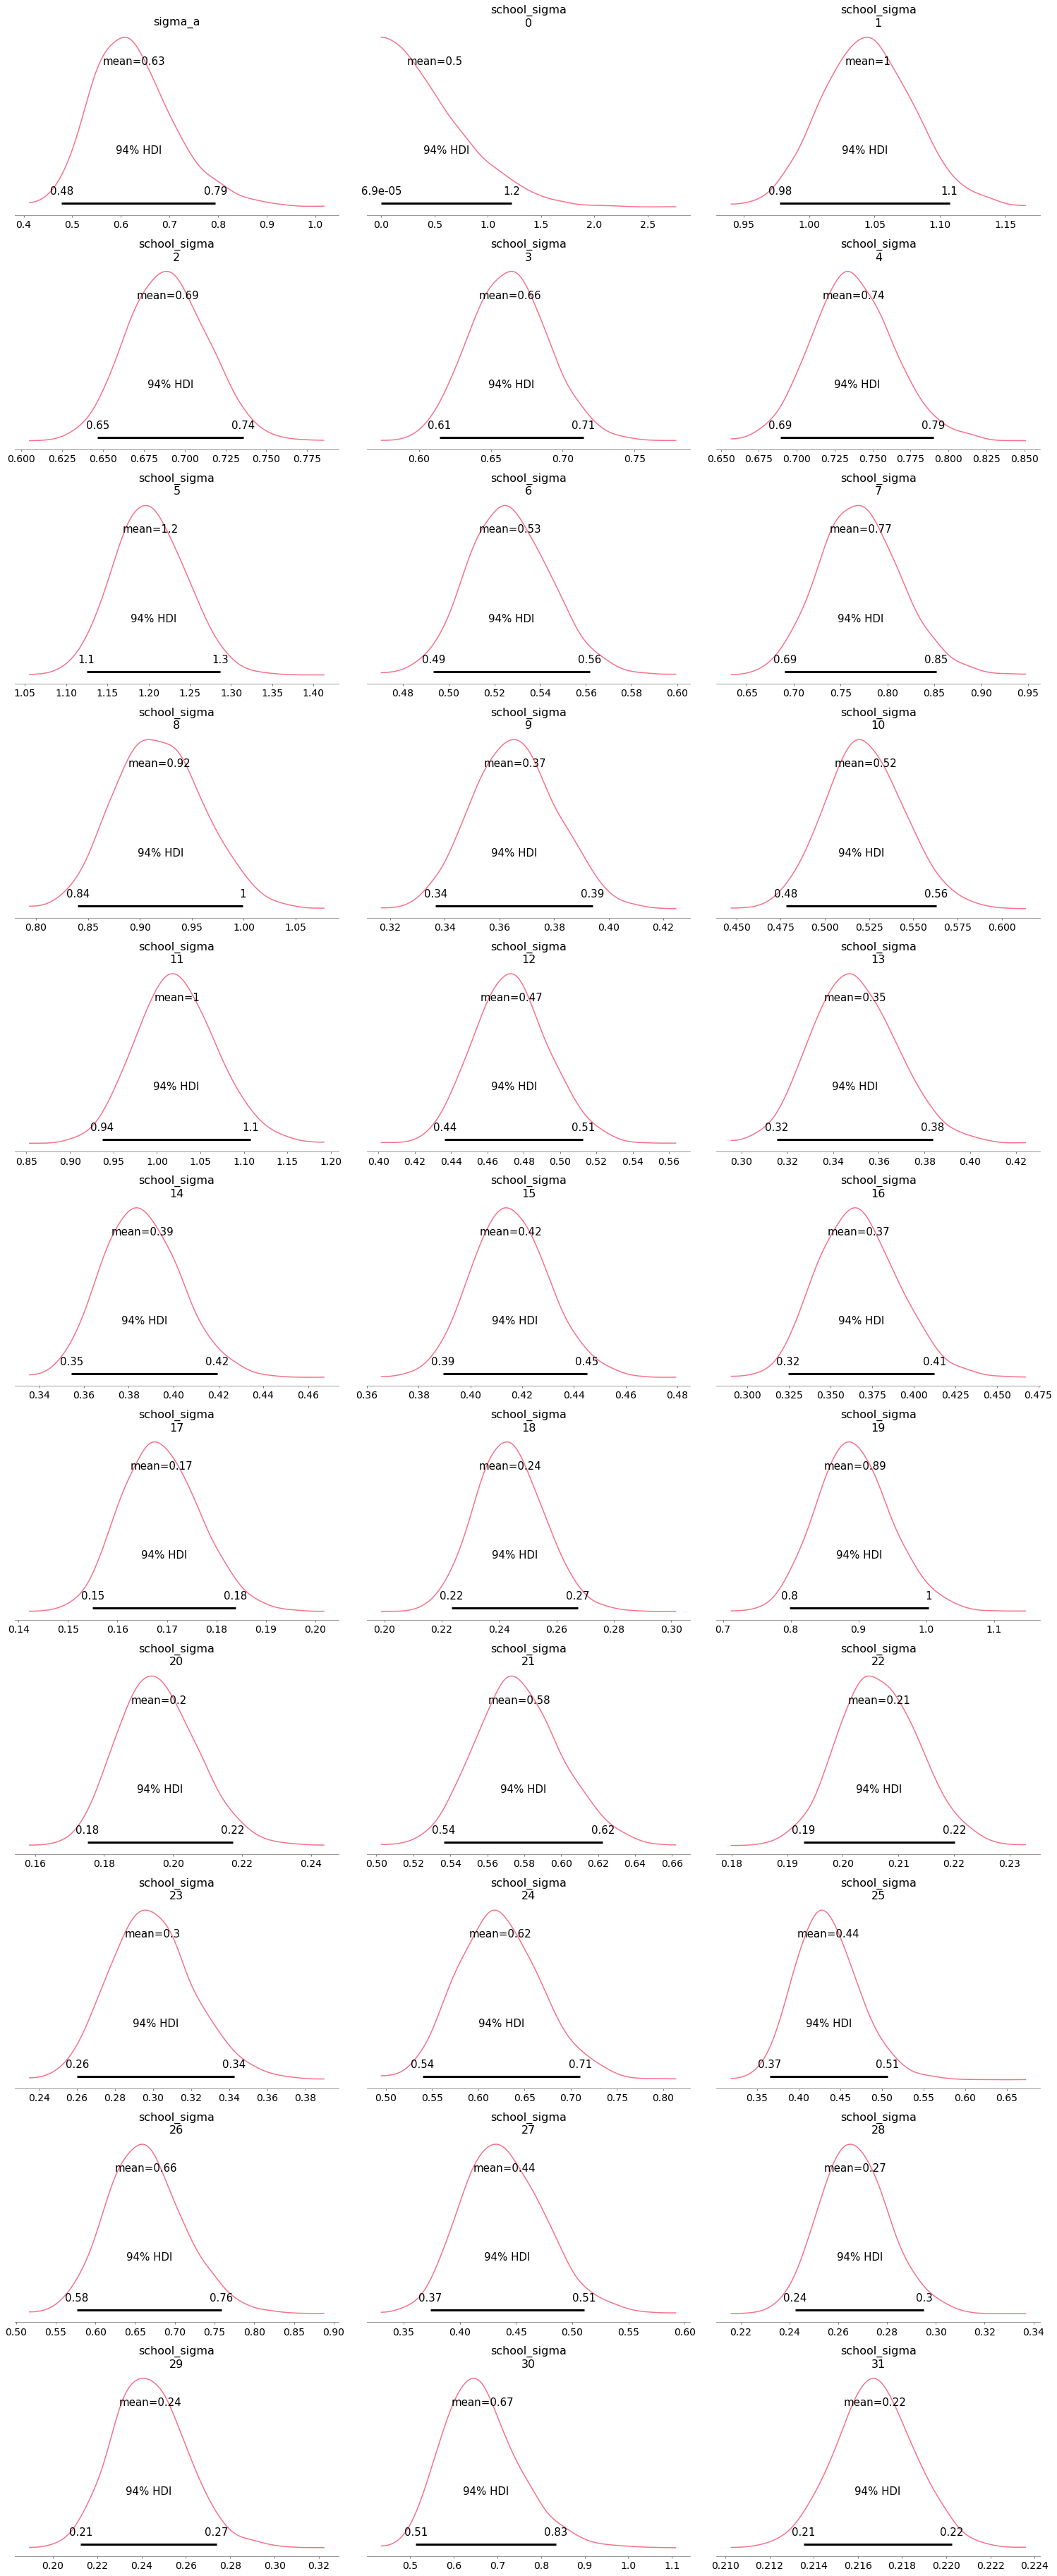

In [128]:
az.plot_posterior(mlm_idata);

## TODO Thursday
*   With the MLM try to compare overall results. PLot the general model
*   Then use the guide to compare models.

In [126]:
mlm_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [ ]:

coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size)}
with pm.Model(coords=coords) as pooled_model:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Level")

    theta = a[floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(pooled_model)



In [159]:
coords = {"obs_id": np.arange(data.index.size), "SchoolRank": np.arange(32)}
with pm.Model(coords=coords) as no_pool_school_model:
    rank_idx = pm.Data("rank_idx", data.Rank.values, dims="obs_id")
    
    # Varying standard dev.
    sigma = pm.HalfNormal("school_sigma", sd=1, dims="SchoolRank")
    
    # Expected value per school
    school_sigma = sigma[rank_idx]
#     school_sigma = pm.HalfNormal("school_sigma", sd=1)

    inf_data_no_pool = pm.HalfNormal("y", sd=school_sigma, observed = data.AERPub_adj, dims="obs_id")
    

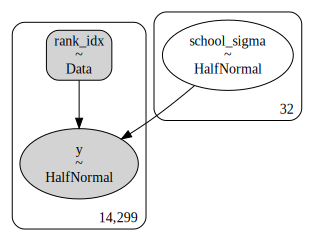

In [160]:
pm.model_to_graphviz(no_pool_school_model)

In [161]:
with no_pool_school_model:
    no_pool_idata = pm.sample(tune=3000, draws=3000, return_inferencedata= True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [school_sigma]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


# Comparing non-pooled vs partial pooling

It seems as though we didn't need to partially pool the data, since the standard deviations of the non-pooled data are almost the same as the pooled variants.

Just to confirm we plot the differences of the standard deviations.

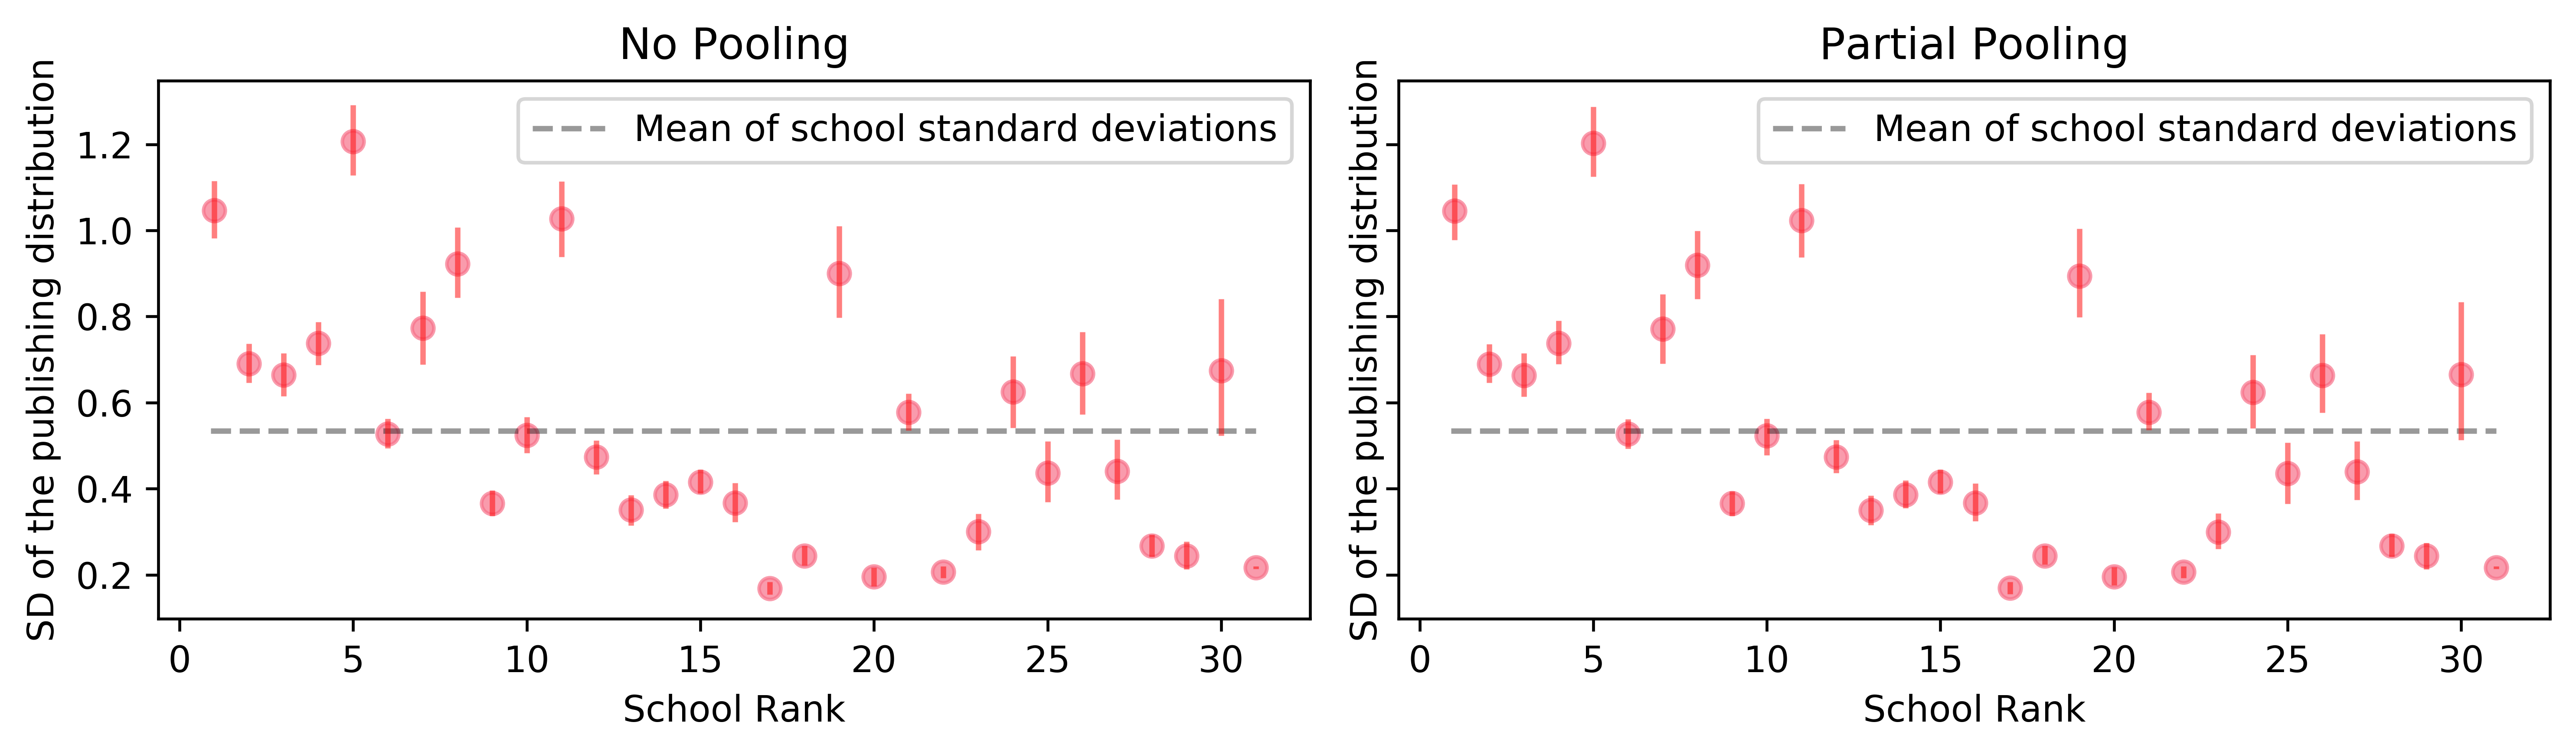

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
fig.set_dpi(600)
for ax, idata, subtitle in zip(axes, (no_pool_idata, mlm_idata), ["No Pooling", "Partial Pooling"]):
    idata = idata.sel(SchoolRank = np.arange(1,32))

    idata.posterior.mean(dim=("chain", "draw")).plot.scatter(x="SchoolRank", y="school_sigma", ax=ax, alpha=0.7);
    ax.hlines(
        mlm_idata.posterior.school_sigma.mean(),
        0.9,
        31,
        alpha=0.4,
        ls="--",
        label="Mean of school standard deviations")

    hdi = az.hdi(idata).school_sigma
    ax.vlines(np.arange(1,32), hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="red", alpha=0.5)

    ax.set(title=subtitle, xlabel="School Rank", ylabel="SD of the publishing distribution")

    ax.legend(fontsize=10)
fig.tight_layout();

In [193]:
partially_pooled_hdis = az.hdi(mlm_idata.sel(SchoolRank = np.arange(1,32))).school_sigma

no_pooled_hdis = az.hdi(no_pool_idata.sel(SchoolRank = np.arange(1,32))).school_sigma

hdis_delta = partially_pooled_hdis - no_pooled_hdis

In [208]:
partially_pooled_sd_means = mlm_idata.sel(SchoolRank = np.arange(1,32)).posterior.mean(dim=("chain", "draw")).school_sigma
no_pooled_sd_means = no_pool_idata.sel(SchoolRank = np.arange(1,32)).posterior.mean(dim=("chain", "draw")).school_sigma

sd_deltas = partially_pooled_sd_means - no_pooled_sd_means

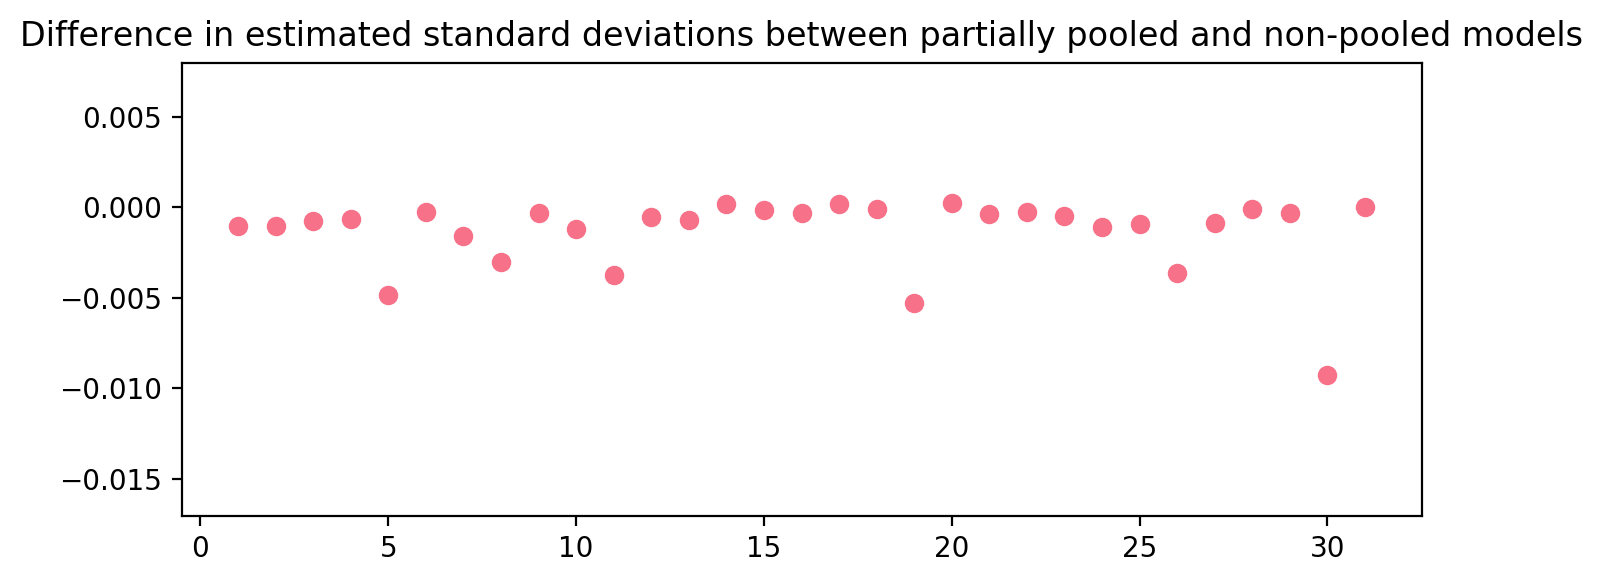

In [210]:
fig, ax = plt.subplots(figsize=(8,3))
fig.set_dpi(200)

ax.scatter(x=np.arange(1,32), y=sd_deltas);
ax.set_title("Difference in estimated standard deviations between partially pooled and non-pooled models");
ax.se

# TODO friday

Determine if my partial pooling was strong enough. The deltas seem to say there is little convergence, though, note that the variance of the non-pooled data was quite low as well (so adding in the shrinkage maybe didn't matter).

- Read the actual paper, then story board my blog